# Lecture 2: Supervised Learning

In this lab, you will learn to decode hand position from neural activity in the primate primary motor cortex (M1) using GLMs and random fores

In [1]:
import numpy as np
import scipy.io
import sklearn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD','b']

# Data
Below we load a dataset available on CRCNS: a [Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream) (from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short)).

The data has been organized in Matlab into neat arrays for easy loading here.

We will soon want a single numpy array representing the external covariates, and a single numpy vector representing the neural response. The data array X will be of dimensions (n, p), where n is the number of time bins and p is the number of covariates, and the response y will be of dimensions (n, ).

#### Load data

In [2]:
m1 = scipy.io.loadmat('data/m1_stevenson_2011.mat')
m1['time'] = m1['time'].squeeze()
m1['sampling_rate'] = 1/np.diff(m1['time']).mean()

In [3]:
m1['time'].shape

(15536,)

In [4]:
m1['sampling_rate']

20.0

### Plot raw M1 data

This gives some intuitive feeling for the type of data we're working with.

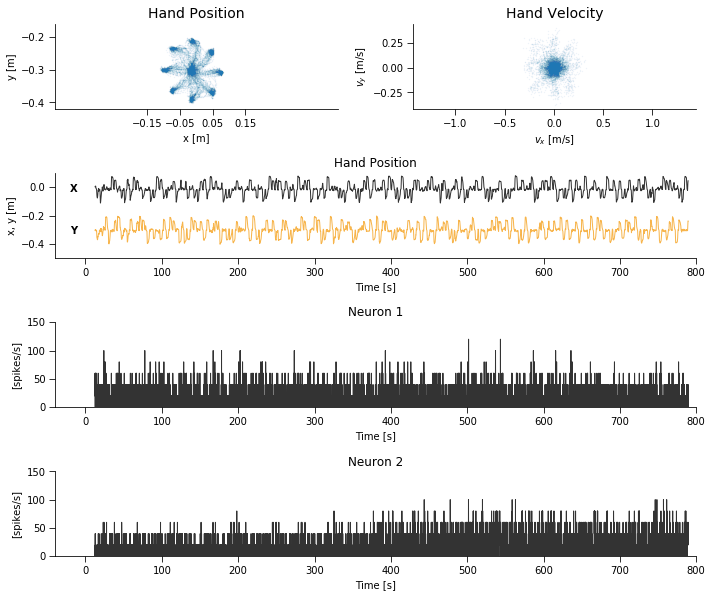

In [5]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'

# Position scatter
ts = 14
gs0 = gridspec.GridSpec(5, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(m1['handPos'][0,:], m1['handPos'][1,:], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
plt.ylim([-0.42,-0.16])
plt.xlim([-0.15,0.15])
plt.xticks(np.arange(-0.15,0.2, .1))

# Velocity scatter
plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(m1['handVel'][0,:], m1['handVel'][1,:], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

# Position trace
plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['handPos'][0,:], 'k-', alpha=alpha, lw=lw)
plt.plot(m1['time'], m1['handPos'][1,:], '-', color=colors[0], alpha=alpha, lw=lw)
a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')


# Neuron 1 firing rate
plt.subplot(gs0[2,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][0,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 1')

# Neuron 1 firing rate
plt.subplot(gs0[3,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][1,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 2')


plt.tight_layout()
plt.show()

## Exercise 1: Decode hand position from neural activity using a linear decoder
### Hints:

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import medfilt

def plot_positions(t, Y_test, Y_predict):
    """Plots true and predicted hand positions over time"""
    plt.figure(figsize=(15,10))
    a=plt.gca()
    simpleaxis(a)
    a.text(np.min(t)-20,-.03,'X',weight='bold')
    a.text(np.min(t)-20,-.33,'Y',weight='bold')
    alpha = 0.9
    lw = 1
    plt.plot(t, medfilt(Y_predict.T[0,:], 5), 'c-', t, Y_test.T[0,:], 'm-', alpha=alpha, lw=lw)
    plt.plot(t, medfilt(Y_predict.T[1,:], 5), 'c-', t, Y_test.T[1,:], 'm-', alpha=alpha, lw=lw)
    plt.legend(['pred', 'true'])
    plt.xlabel('Time [s]')
    plt.ylabel('x, y [m]')
    plt.title('Hand Position')
    plt.show()
    
def mean_absolute_percentage_error(Y_test, Y_predict):
    return float(np.mean(np.abs((Y_test - Y_predict)/Y_predict)))

def score_positions(Y_test, Y_predict):
    """Scores given hand positions using standard metrics"""
    return (mean_squared_error(Y_test, Y_predict),
            mean_absolute_error(Y_test, Y_predict),
            r2_score(Y_test, Y_predict),
            mean_absolute_percentage_error(Y_test, Y_predict))

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

In [8]:
print(Y.shape), print(Y[0:10])  # hand position in x and y dimensions
print(X.shape), print(X[0:10])  # neural activity for 171 neurons
print(t.shape), print(t[0:10])  # time points

(15536, 2)
[[ 0.00290536 -0.30363576]
 [ 0.00225992 -0.30386895]
 [ 0.00239867 -0.30363108]
 [ 0.00400953 -0.3023991 ]
 [ 0.00638562 -0.30067273]
 [ 0.00778057 -0.3013095 ]
 [ 0.00779657 -0.30362235]
 [ 0.00768893 -0.3050522 ]
 [ 0.00789962 -0.30560121]
 [ 0.00787911 -0.30559552]]
(15536, 171)
[[1 0 2 ... 2 0 2]
 [3 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 3]
 ...
 [1 0 2 ... 3 0 1]
 [1 1 3 ... 0 0 2]
 [1 1 2 ... 2 0 2]]
(15536,)
[12.591 12.641 12.691 12.741 12.791 12.841 12.891 12.941 12.991 13.041]


(None, None)

In [9]:
import sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

In [10]:
# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=5)

In [11]:
import sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

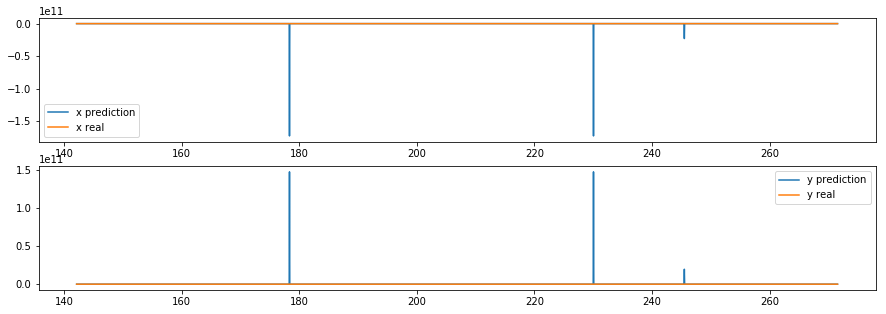

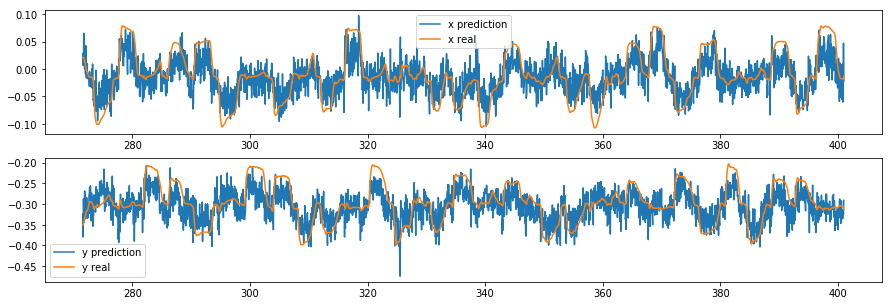

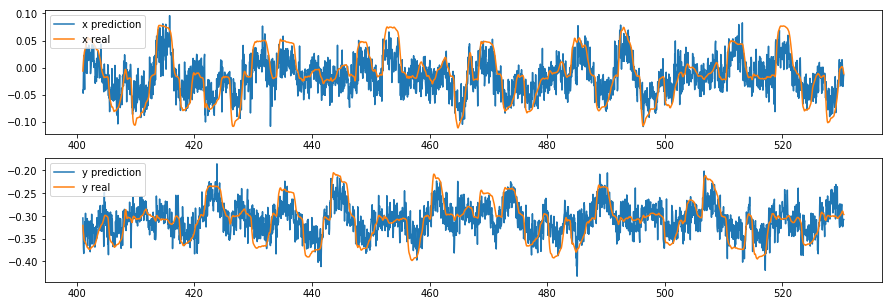

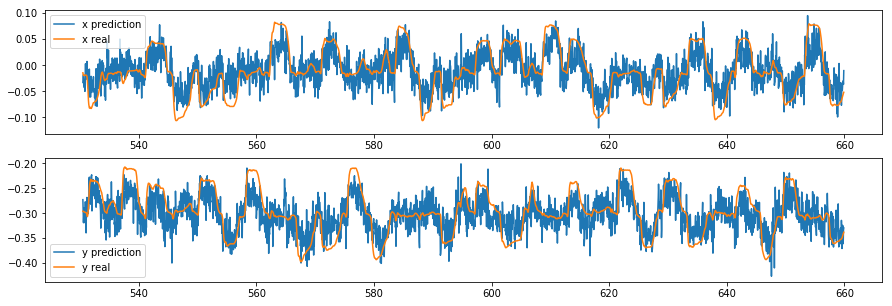

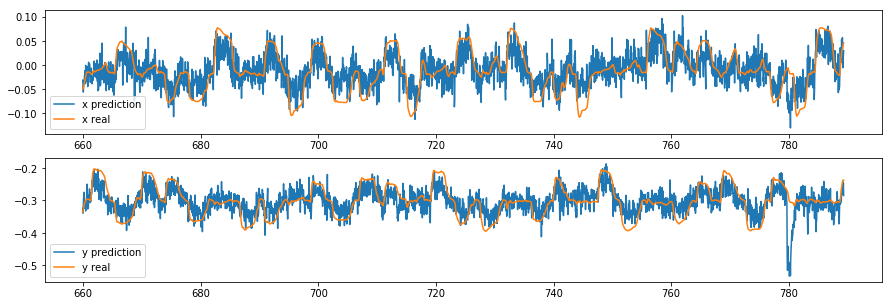

In [12]:
# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index,np.newaxis], t[test_index,np.newaxis]
    
#     print(X_train.shape), print(X_test.shape)
#     print(Y_train.shape), print(Y_test.shape)
#     print(t_train.shape), print(t_test.shape)
    
    """
    Fit your linear regression model here, extract relevant metrics and plot test performance.
    """
    
    # Train model on x and y position data separately
    # This is going to give you a different result from training the model concurrently
    # with both x and y position data because -- and I don't know what how does the
    # regression model use the data under the hood -- the matrix `b` is going to be different
    # i.e. the constraints to the systems of linear equations are going to be different too
    
    # predict x position
    x_model = LinearRegression()
    x_model.fit(X_train, Y_train[:,0])
    
    x_predict = x_model.predict(X_test)
    x_predict = x_predict.reshape([-1,1])
    
    # predict y position
    y_model = LinearRegression()
    y_model.fit(X_train, Y_train[:,1])
    
    y_predict = y_model.predict(X_test)
    y_predict = y_predict.reshape([-1,1])    
        
    linear_fig, linear_ax = plt.subplots(2,1,figsize=(15,5))
    linear_ax[0].plot(t_test,x_predict,label='x prediction')
    linear_ax[0].plot(t_test,Y_test[:,0],label='x real')
    linear_ax[1].plot(t_test,y_predict,label='y prediction')
    linear_ax[1].plot(t_test,Y_test[:,1],label='y real')
    
    # linear_ax[0].set_ylim([-0.1,0.1])
    # linear_ax[1].set_ylim([-0.45,-0.2])
    linear_ax[0].legend()
    linear_ax[1].legend()

MSE: 20137584280928985088.000000
MAE: 132042418.168646
COD: -10288706939153970888704.000000
MAP: 2.222570


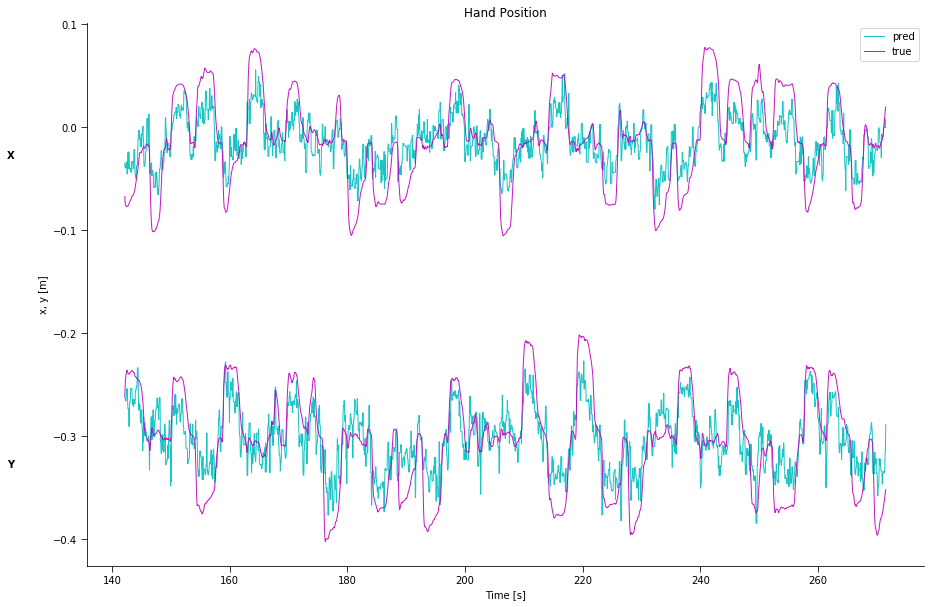

MSE: 0.001016
MAE: 0.025440
COD: 0.489944
MAP: 4.766849


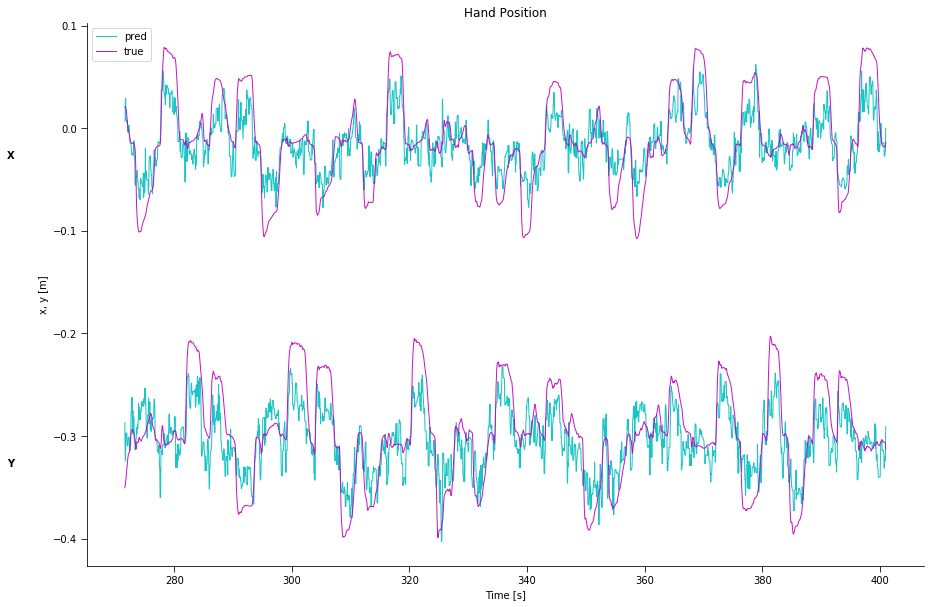

MSE: 0.000961
MAE: 0.024905
COD: 0.505497
MAP: 5.138205


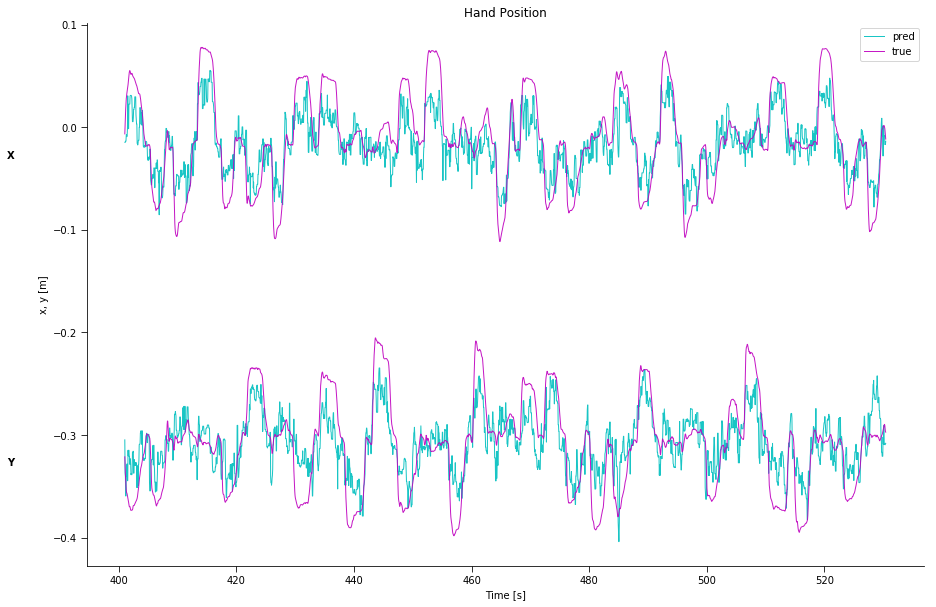

MSE: 0.000952
MAE: 0.024770
COD: 0.527254
MAP: 28.527663


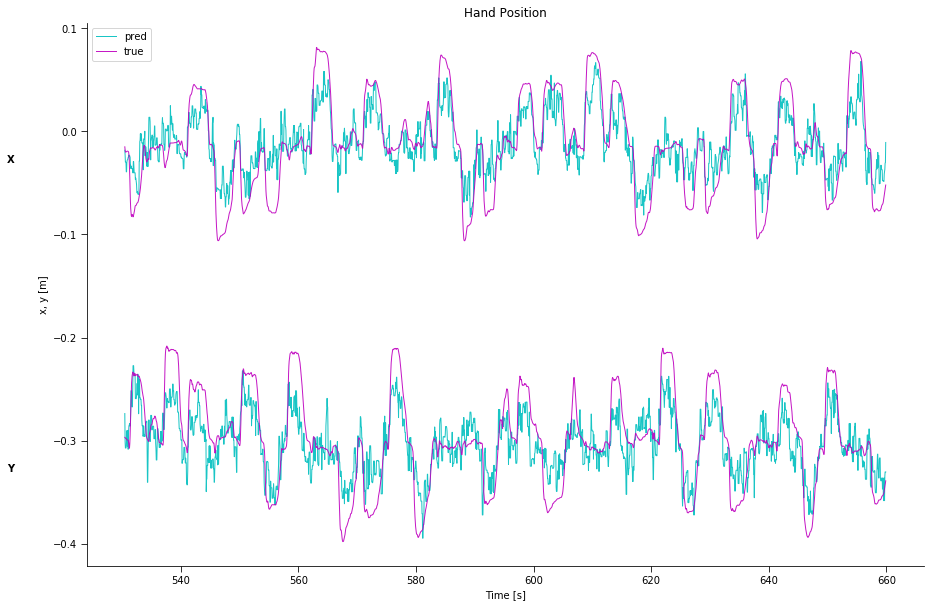

MSE: 0.001122
MAE: 0.025782
COD: 0.438802
MAP: 1.753478


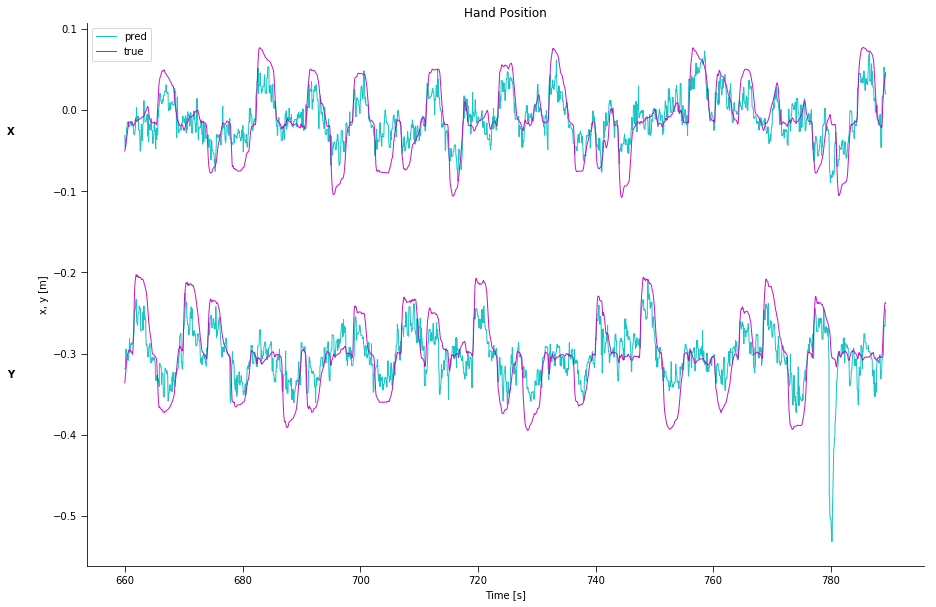

In [13]:
# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index,np.newaxis], t[test_index,np.newaxis]
    
#     print(X_train.shape), print(X_test.shape)
#     print(Y_train.shape), print(Y_test.shape)
#     print(t_train.shape), print(t_test.shape)
    
    """
    Fit your linear regression model here, extract relevant metrics and plot test performance.
    """
    
    Y_model = LinearRegression()
    Y_model.fit(X_train, Y_train)
    
    Y_predict = Y_model.predict(X_test)
#     print(Y_predict.shape)
    
    MSE, MAE, COD, MAP = score_positions(Y_test,Y_predict)
    print("MSE: %f" % MSE)
    print("MAE: %f" % MAE)
    print("COD: %f" % COD)
    print("MAP: %f" % MAP)
    plot_positions(t_test,Y_test,Y_predict)

MSE: 0.0010110152729565774
MAE: 0.025649294042817385
COD: 0.49596602961637776
MAPE: 2.6048403528547275


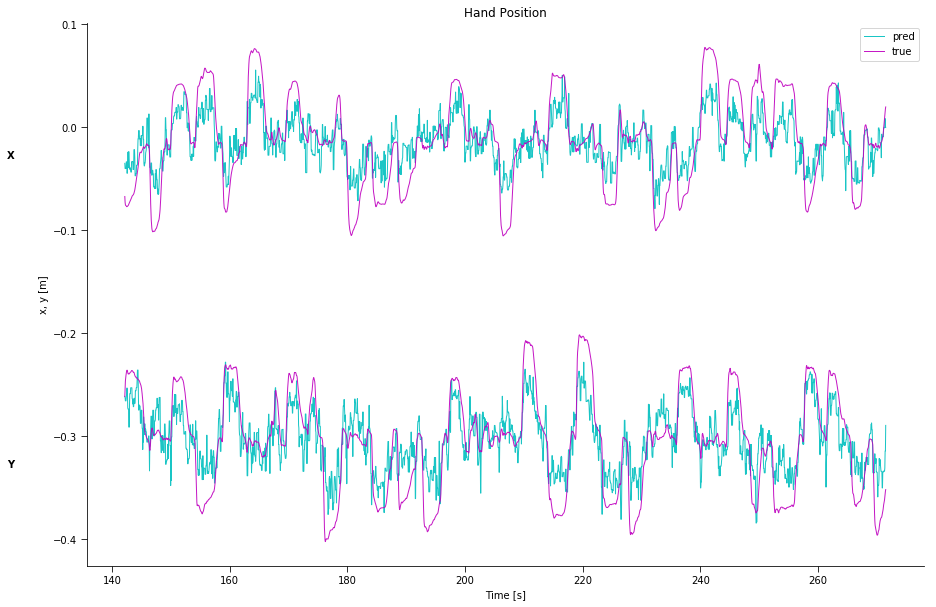

MSE: 0.001007357591612029
MAE: 0.025343890794138936
COD: 0.4941064415823518
MAPE: 2.3011950209757632


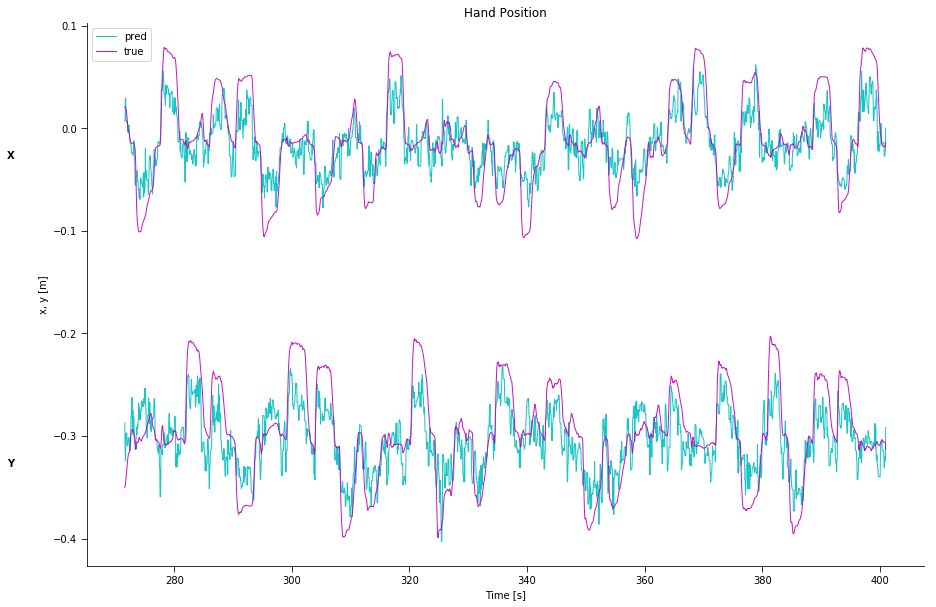

MSE: 0.0009605984908681179
MAE: 0.024905825825075986
COD: 0.5059302626453577
MAPE: 2.0104161497174533


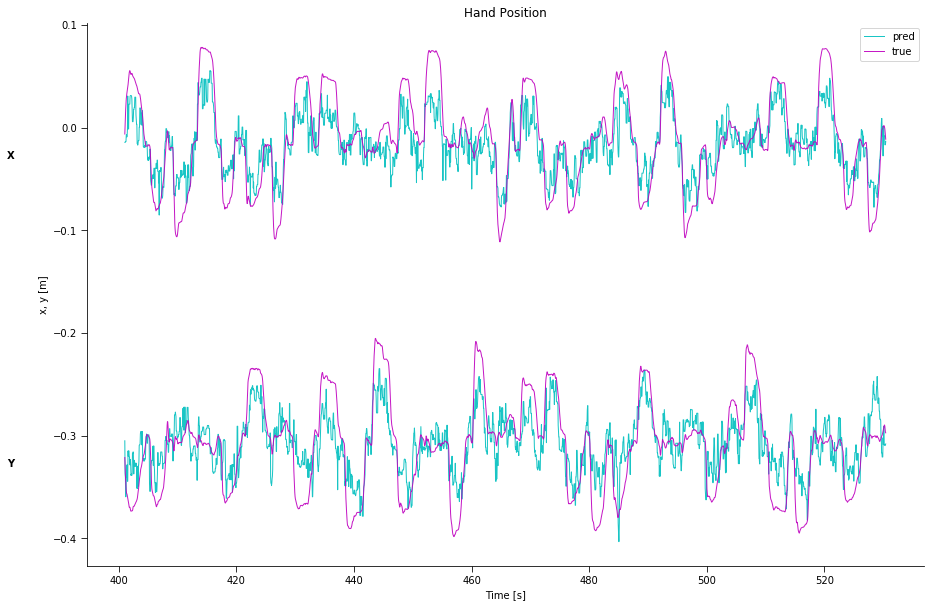

MSE: 0.0009517210816458663
MAE: 0.024772737288010764
COD: 0.5273198305910061
MAPE: 3.314966885525544


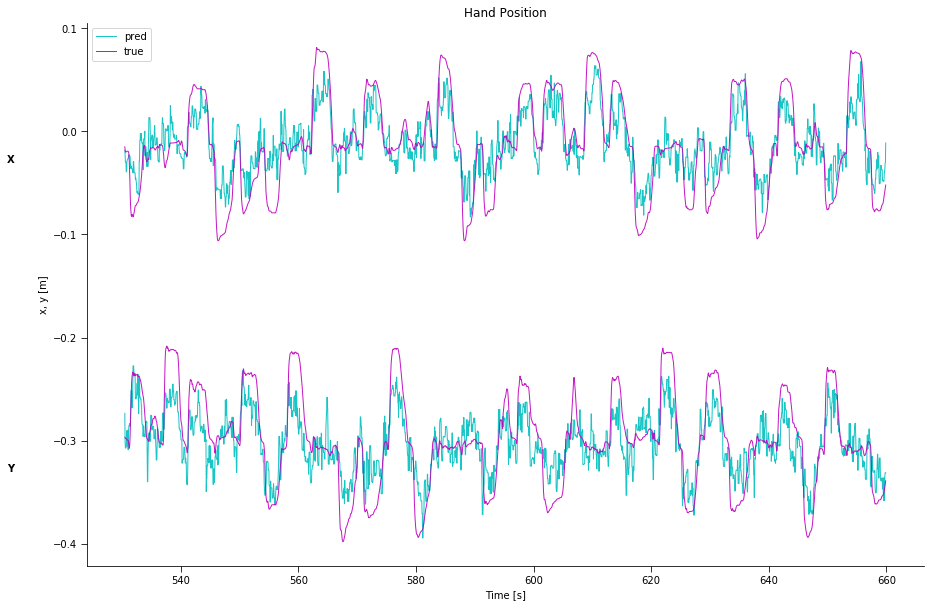

MSE: 0.001120026846754685
MAE: 0.02577164081673501
COD: 0.43979134541510306
MAPE: 1.7886127402754288


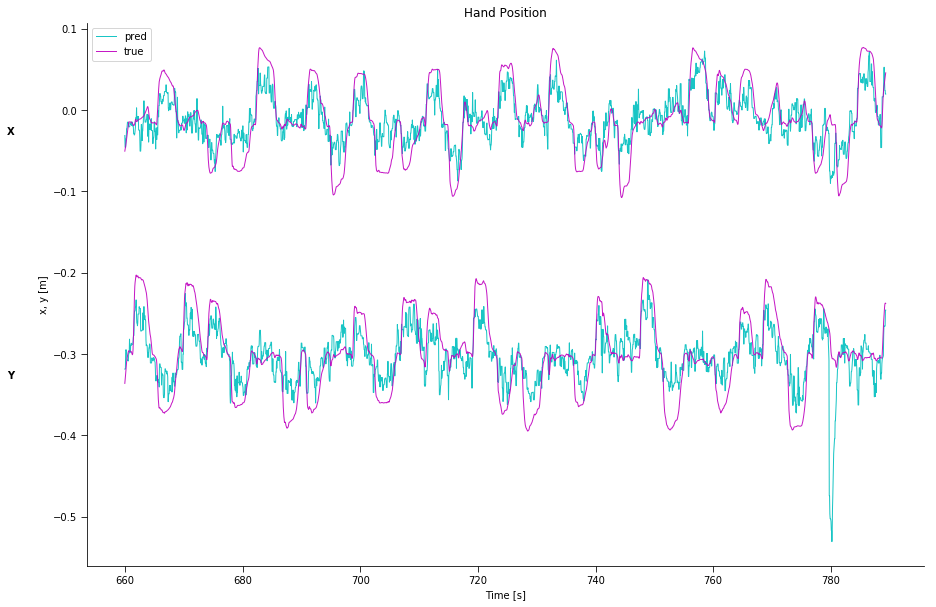

avg MSE: 0.001010143856767455
avg MAE: 0.025288677753355616
avg COD: 0.4926227819700393
avg MAPE: 2.4040062298697835


In [26]:
# hints / answers
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=5)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Fit your linear regression model here, extract relevant metrics and plot test performance.
    """

## Exercise 2: Find the 10 best neurons for decoding hand position
### Hints:

In [17]:
sub_alpha

[0]

exited at 0.009091, where num of neurons: 10
70 70


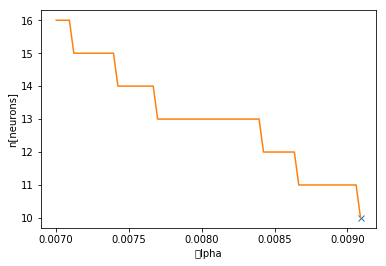

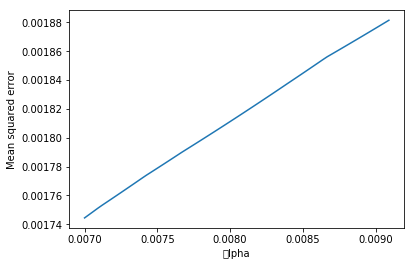

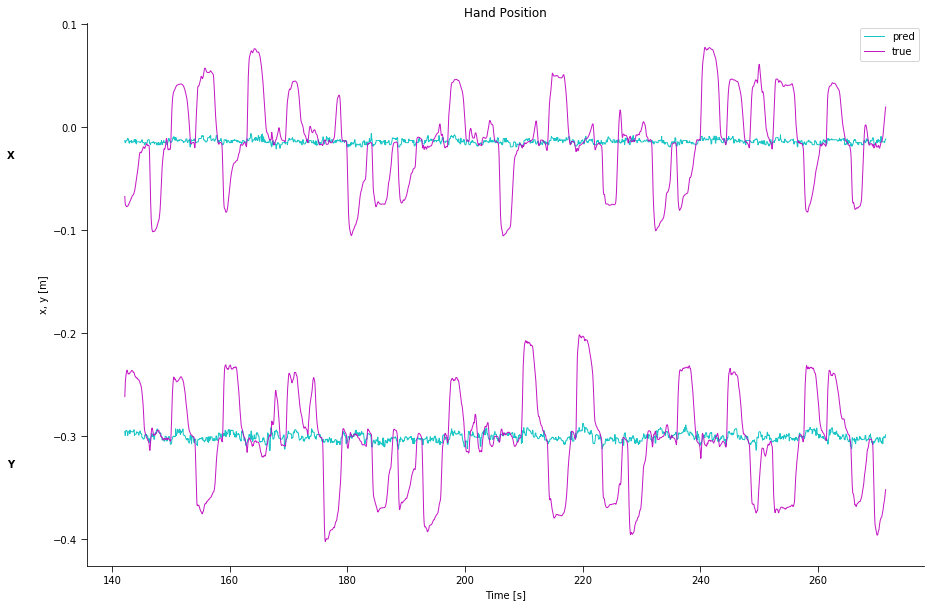

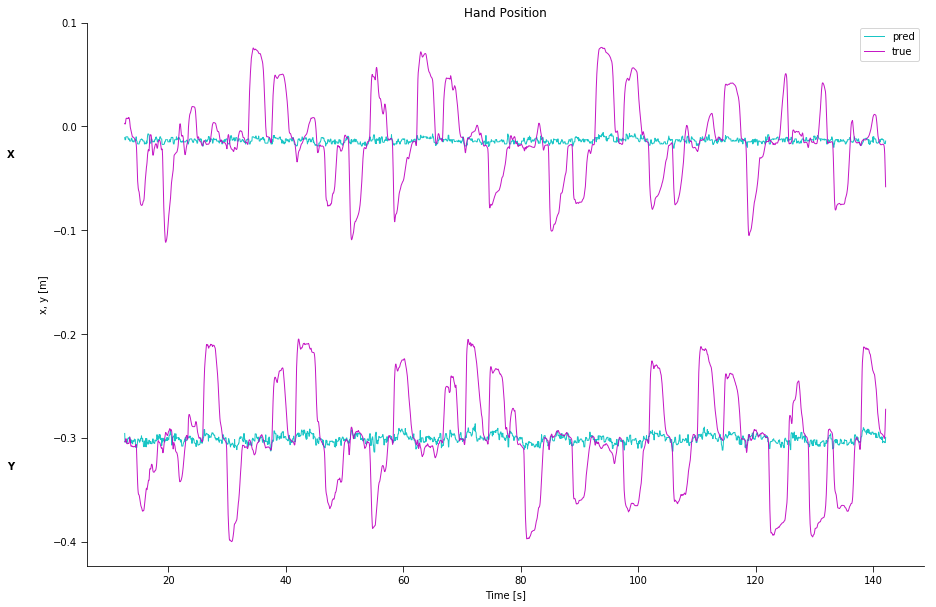

(2591,) (2591, 2) (2591, 2)
exited at 0.008909, where num of neurons: 10
64 64


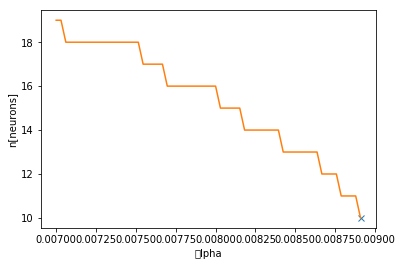

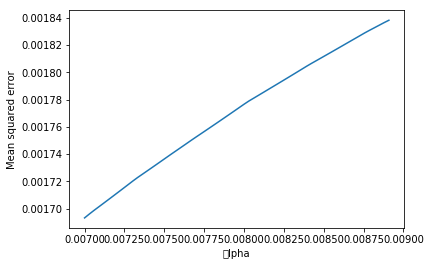

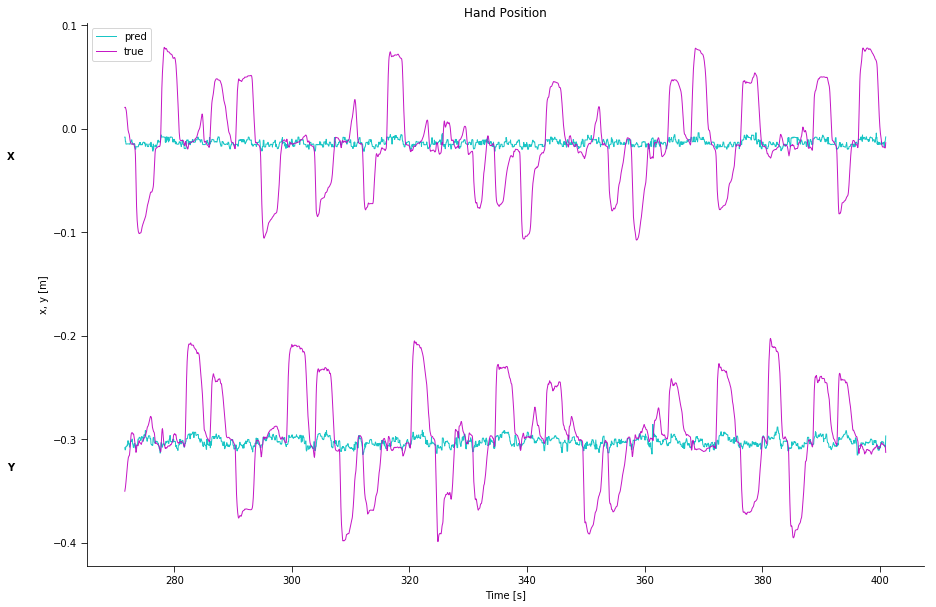

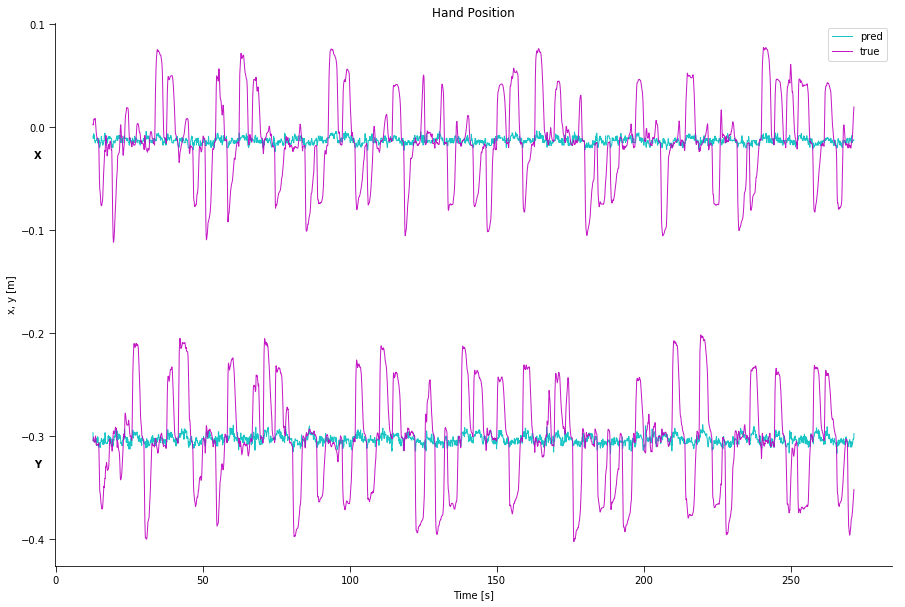

(5180,) (5180, 2) (5180, 2)
exited at 0.008848, where num of neurons: 10
62 62


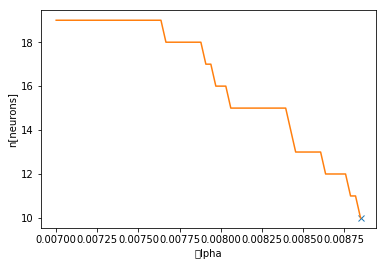

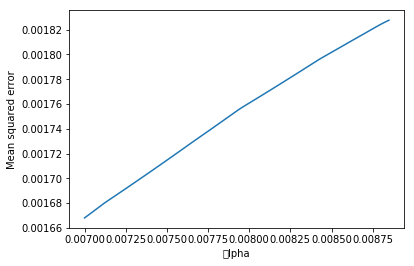

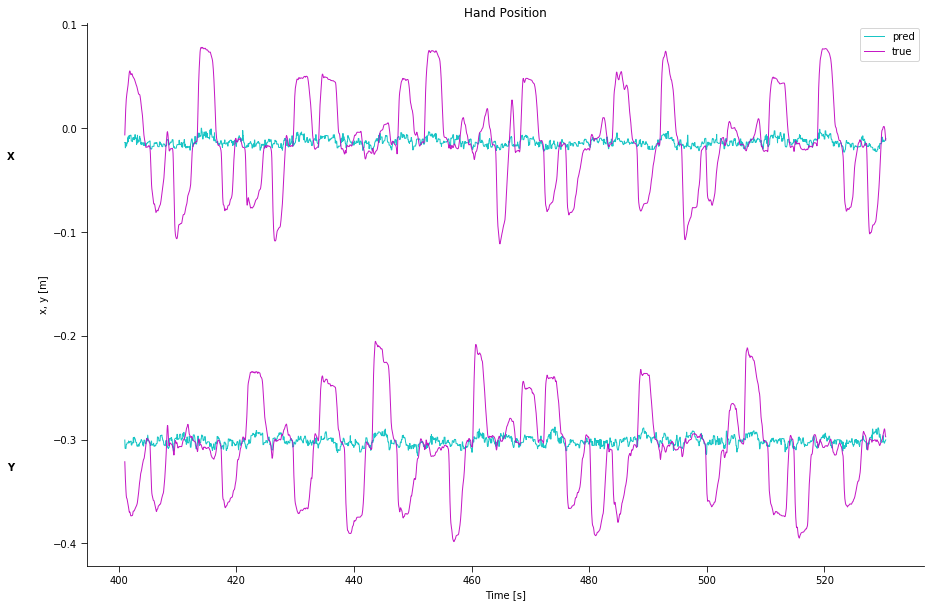

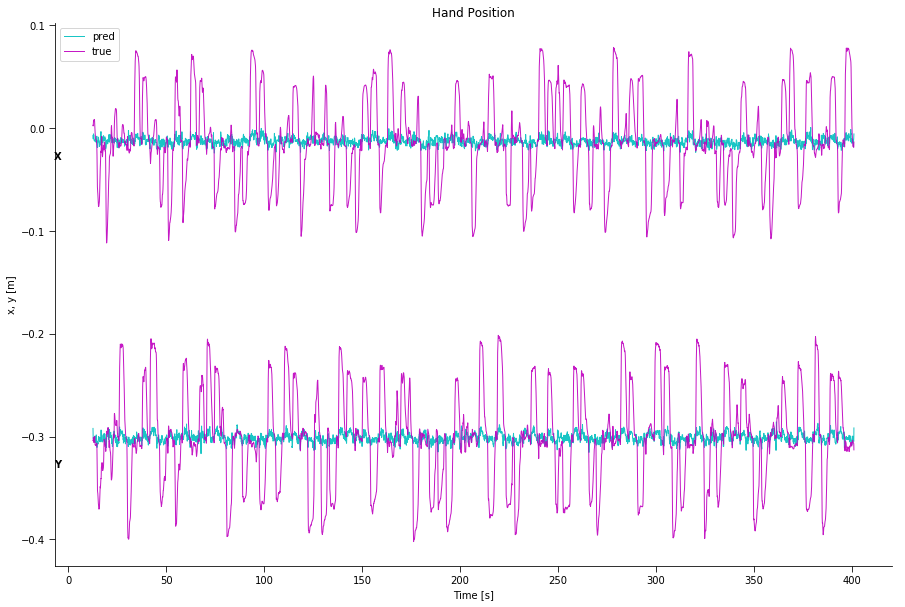

(7769,) (7769, 2) (7769, 2)
exited at 0.009303, where num of neurons: 10
77 77


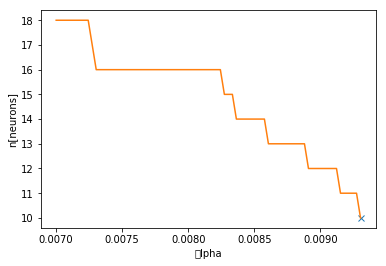

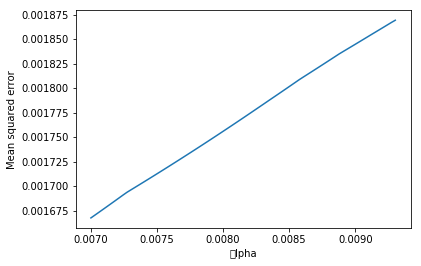

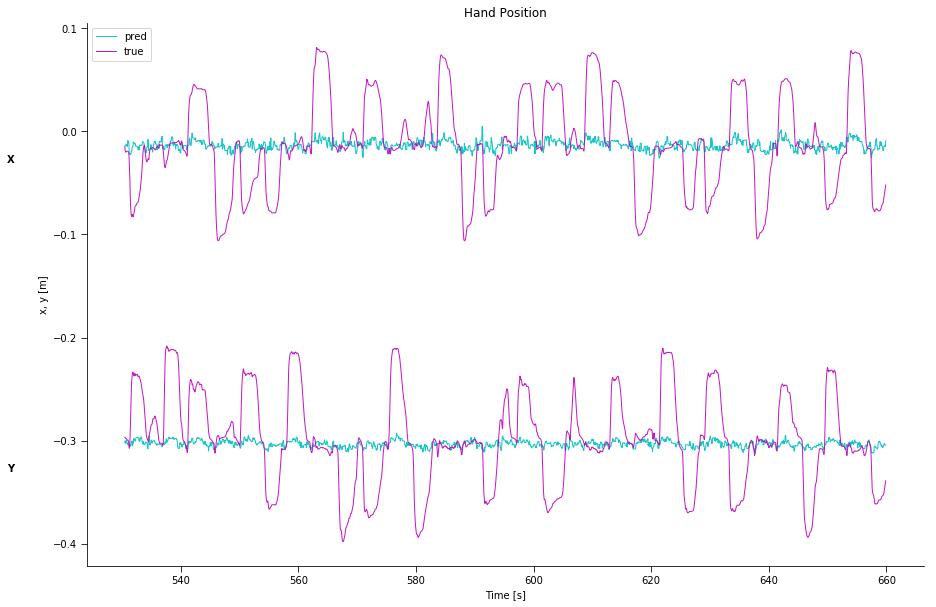

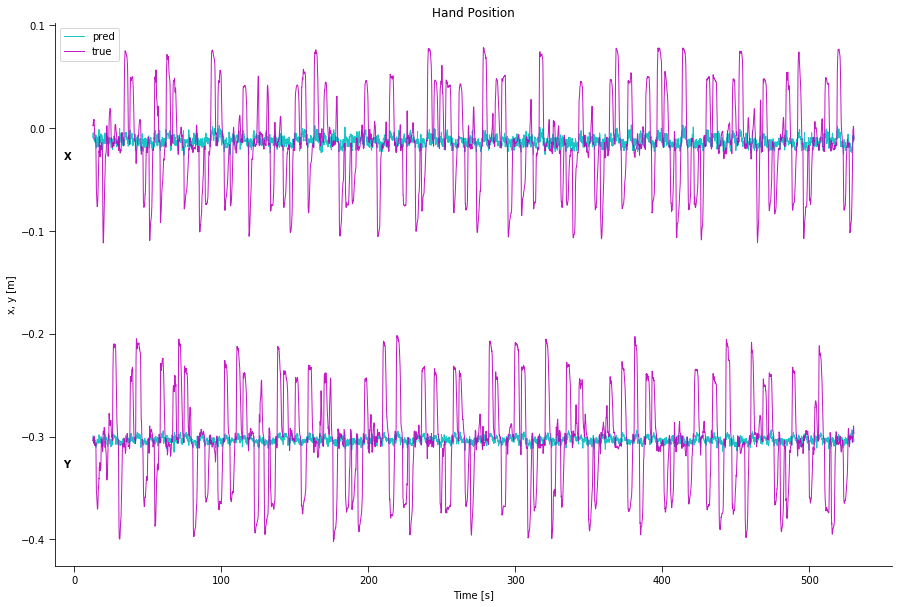

(10358,) (10358, 2) (10358, 2)
exited at 0.009273, where num of neurons: 10
76 76


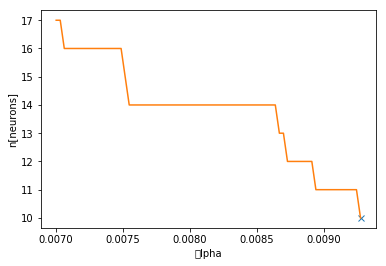

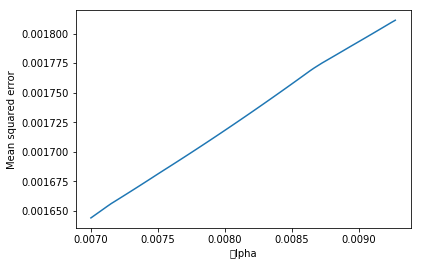

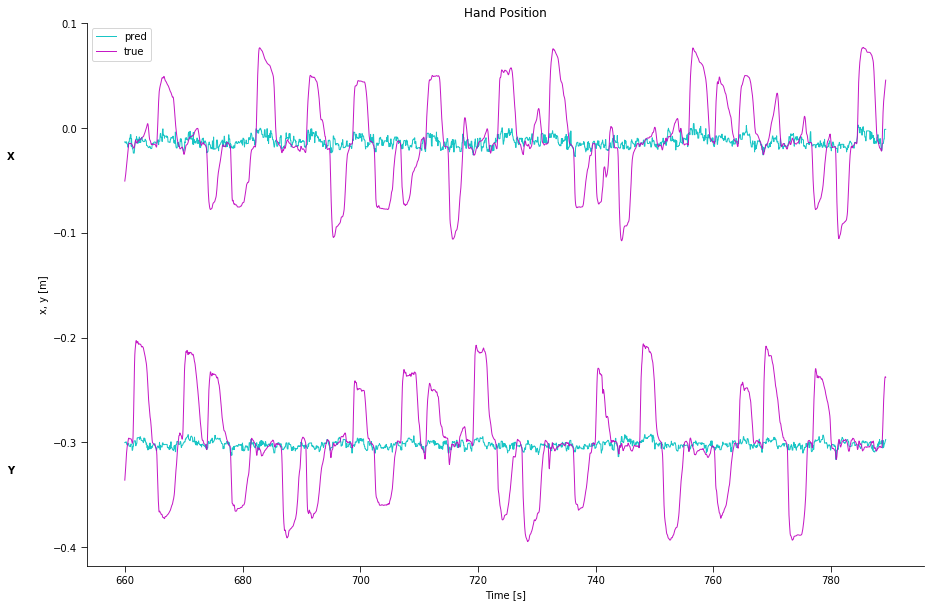

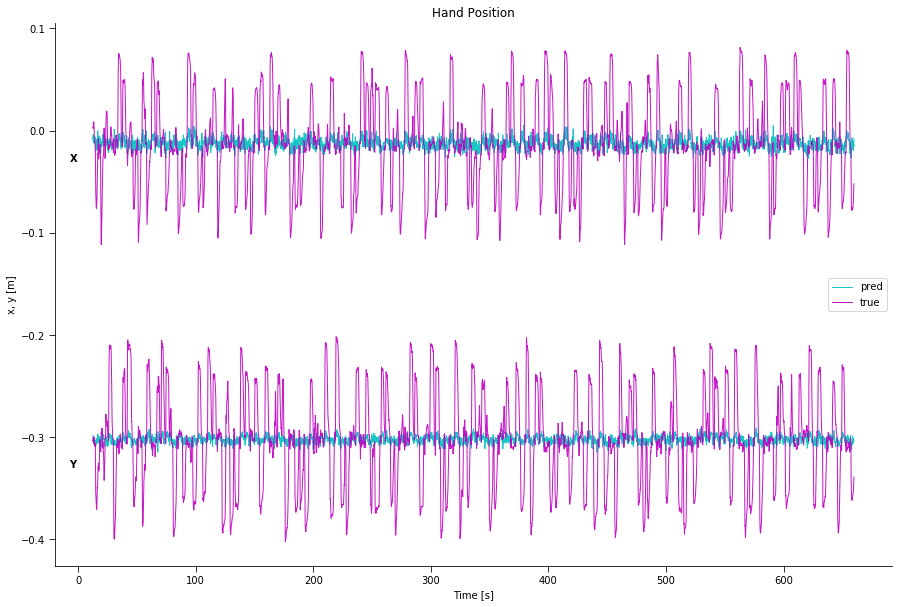

(12947,) (12947, 2) (12947, 2)


In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=5)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Fit your linear regression model with L1 regularization (lasso) here, 
    extract relevant metrics and plot test performance.
    """
    
    # Find the 10 best neurons using the regularization tree
    
    alpha_lasso = np.linspace(0.007,0.01,100)
    alpha_ten = []
    sub_alpha = []  # save regularization factor alpha
    sub_coeff = []  # save number of neurons for plotting
    n_coeff = []
    
    mse_alpha = []
    
    # plot figure of alpha value vs number of neurons
    plt.figure()
    
    for alpha in alpha_lasso:
        
        Y_model = Lasso(alpha=alpha)
        Y_model.fit(X_train, Y_train)

        Y_predict = Y_model.predict(X_test)
        
        num_coeff = np.count_nonzero(np.linalg.norm(Y_model.coef_,axis=0))
        n_coeff.append(num_coeff)
        
        MSE, MAE, COD, MAP = score_positions(Y_test,Y_predict)
        mse_alpha.append(MSE)
#         print("MSE: %f" % MSE)
#         print("MAE: %f" % MAE)
#         print("COD: %f" % COD)
#         print("MAP: %f" % MAP)        
        
        # the number of neurons / coefficients should decrease as the alpha values /
        # regularization factor increase
        # save the alpha value and number of neurons for plotting
        if num_coeff > 10:
            sub_alpha.append(alpha)
            sub_coeff.append(num_coeff)        
        elif num_coeff == 10:
            plt.plot(alpha,num_coeff,'x')  # plot current alpha value and number of neurons
            sub_alpha.append(alpha)
            sub_coeff.append(num_coeff)
            print('exited at %f, where num of neurons: %i' % (alpha,num_coeff))
            break
        else:  # when number of neurons < 10
            print('broken at %f, where num of neurons: %i' % (alpha,num_coeff))
            break
            
    print(len(sub_alpha),len(sub_coeff))
    plt.plot(sub_alpha,sub_coeff)
    # plt.xscale('log')
    plt.xlabel('\alpha')
    plt.ylabel('n[neurons]')
    
    plt.figure()
    plt.plot(sub_alpha,mse_alpha)
    plt.xlabel('\alpha')
    plt.ylabel('Mean squared error')

    plot_positions(t_test,Y_test,Y_predict)
    
    # check how well does the model predict with training data
    Y_predict_train = Y_model.predict(X_train)
    plot_positions(t_train,Y_train,Y_predict_train)
    
    print(t_train.shape,Y_train.shape,Y_predict_train.shape)

## Exercise 3: Build the best possible nonlinear decoder
### Hints:

MSE: 0.001052162840924875
MAE: 0.02573480992298327
COD: 0.47362244629422107
MAPE: 2.888956727458987


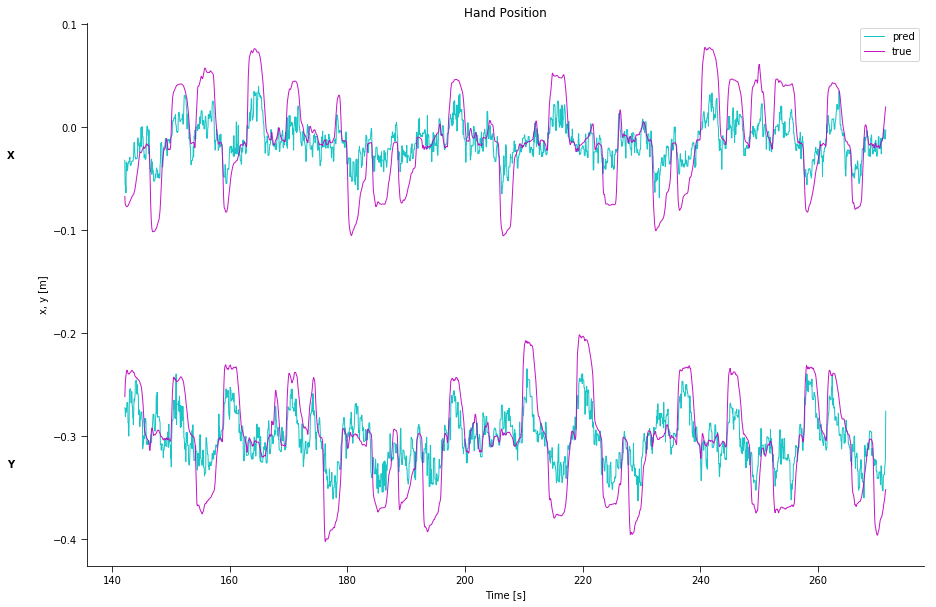

MSE: 0.0010059595296915505
MAE: 0.02503445864703542
COD: 0.49216562340948167
MAPE: 3.979529242243102


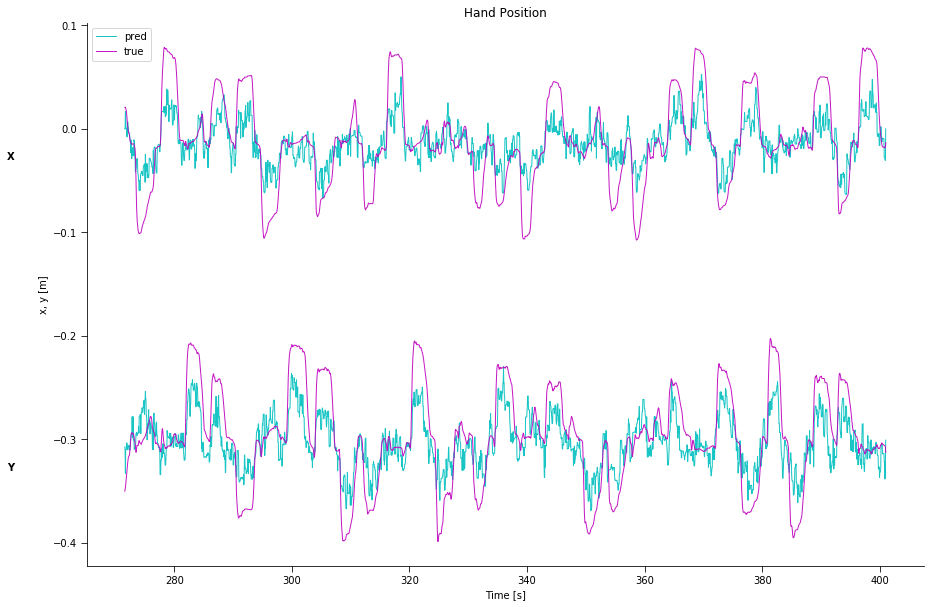

MSE: 0.0009664488907003609
MAE: 0.02446737818684082
COD: 0.5030491768457519
MAPE: 5.728445697170871


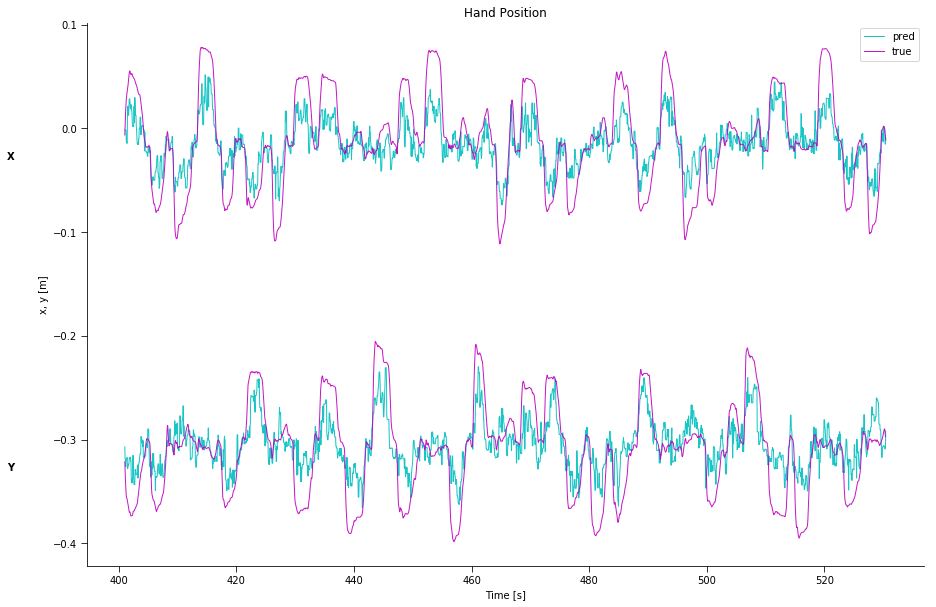

MSE: 0.0009389476194875447
MAE: 0.024236623159157
COD: 0.5340426275203336
MAPE: 2.634032179363878


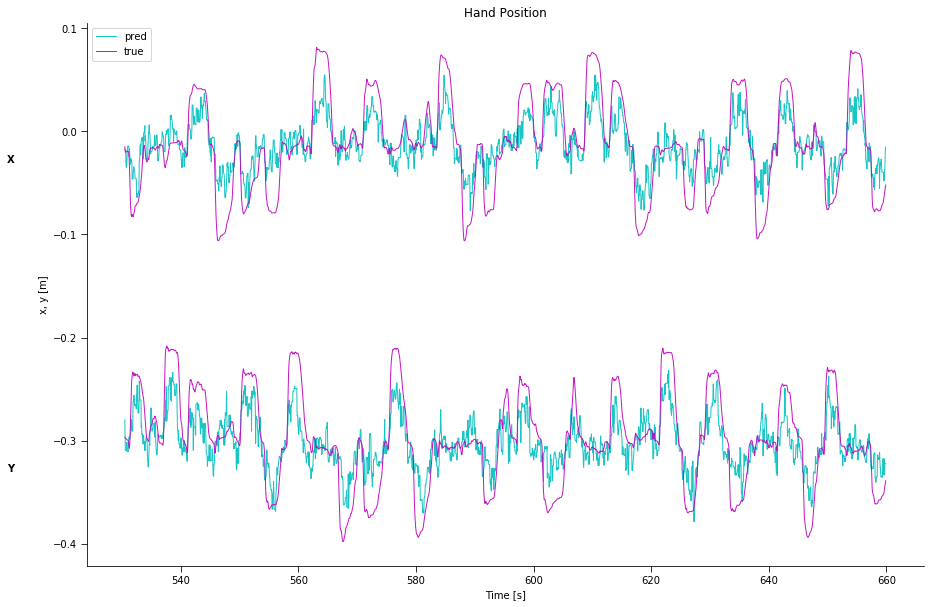

MSE: 0.0009701201576168682
MAE: 0.024584138169509558
COD: 0.5104135180058291
MAPE: 1.872339616218269


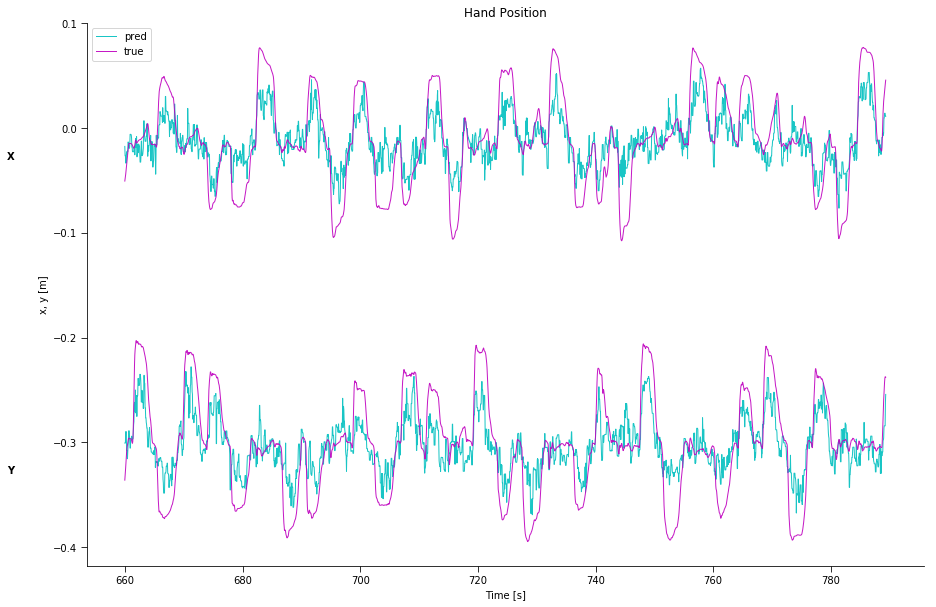

avg MSE: 0.0009867278076842398
avg MAE: 0.024811481617105214
avg COD: 0.5026586784151235
avg MAPE: 3.4206606924910212


In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets
tscv = TimeSeriesSplit(n_splits=5)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Experiment and find/implement the best performing non-linear model here, 
    start with a Random Forest Classifier and compare your results to the linear models, iterate.
    Extract relevant metrics and plot test performance.
    """

## Exercise 4: Build an encoding model for neuron 0 to predict neural activity from hand position and velocity using a linear-nonlinear-Poisson GLM

Use `statsmodels`

Install using `pip install statsmodels`

### Hints:

In [7]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [8]:
# function to convert cartesian coordinates to radial coordinates
def convert_2_angular_coord(Y):
    radius = np.sqrt(Y[:,0]**2+Y[:,1]**2).reshape([-1,1])
    radius = radius
    angle = np.angle(Y[:,0]+Y[:,1]*1j, deg=False).reshape([-1,1])
    angle = np.cos(angle)
    return radius, angle

# create meshgrid to plot tuninng curves
def create_dummy_xy_coordinates(Y_centered):
    ''' return augmented dummy Y - Tx [1, x_coord, y_coord]'''
    ymax = Y_centered.max(axis = 0).max()
    ymin = Y_centered.min(axis = 0).min()
    x_coord = np.arange(ymin, ymax, 0.01)
    y_coord = np.arange(ymin, ymax, 0.01)
    xx_cart_coord, yy_cart_coord = np.meshgrid(x_coord, y_coord)
    return xx_cart_coord, yy_cart_coord

def augment_data(Y):
    return np.hstack([np.ones([Y.shape[0],1]),Y]) 

In [9]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)

# convert to radial coordinate
radius, angle = convert_2_angular_coord(Y)
# don't forget to add a bias term
Y_rad = augment_data(np.hstack([radius, angle]))

# combine both?
Y_comb = np.hstack([Y_cart, radius, angle])


In [10]:
# select your favourite neurons
best_neurons = [0, 2, 141, 32, 111, 50, 59, 48, 16, 98, 154]

In [11]:
# generate dummy hand coordinates in both cartesian and radial coordinates
# for cartesian coordinates
xx_cart_coord, yy_cart_coord  = create_dummy_xy_coordinates(Y_centered)
Y_cart_dummy = augment_data(np.vstack([ xx_cart_coord.flatten(), yy_cart_coord.flatten()]).T )   

# repeat for radial coordinates
radius_dummy, angle_dummy = convert_2_angular_coord(Y_cart_dummy[:,1:3])
Y_rad_dummy = augment_data(np.hstack([radius_dummy, angle_dummy]))

# repeat for both (or add your favourite features)
Y_comb_dummy = np.hstack([Y_cart_dummy, radius_dummy, angle_dummy])

In [12]:
def run_model(neuron_num, X, Y_cart, Y_cart_dummy, xx_cart):
    ## split data
    ## create a model
    ## fit model
    ## predict firing rate on dummy grid
    return poisson_model, results, rate_pred, data

In [13]:
poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
run_model(best_neurons[0], X, Y_cart, Y_cart_dummy, xx_cart_coord)

poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
run_model(best_neurons[0], X, Y_rad, Y_rad_dummy, xx_cart_coord)

poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
run_model(best_neurons[0], X, Y_comb, Y_comb_dummy, xx_cart_coord)

In [14]:
print(results_cart.summary())
print(results_radial.summary())
print(results_comb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10311.
Date:                Tue, 18 Sep 2018   Deviance:                       11025.
Time:                        13:34:31   Pearson chi2:                 1.09e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5835      0.013    -44.424      0.000      -0.609      -0.558
x1            -0.7235      0.307     -2.360      0.0

In [15]:
def plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title):
    fig = plt.figure(figsize = (21,10))
    extent = [xx_cart_coord[0,0],xx_cart_coord[-1,-1], xx_cart_coord[0,0],xx_cart_coord[-1,-1]] 
    fig.add_subplot(1,3,1)
    plt.imshow(rate_pred_cart, extent = extent)
    plt.title('predicted firing rate with \ncartesian basis', fontsize = 23)
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    fig.add_subplot(1,3,2)
    plt.imshow(rate_pred_radial, extent = extent)
    plt.title('predicted firing rate with \nradial basis', fontsize = 23)
    plt.yticks([])
    plt.xlabel('x coordinate')

    fig.add_subplot(1,3,3)
    plt.imshow(rate_pred_comb, extent = extent)
    plt.title('predicted firing rate with \nboth feature vector', fontsize = 23)

    plt.yticks([])
    plt.xlabel('x coordinate')
    plt.suptitle(title)
    # plt.ylabel('y coordinate')
    plt.tight_layout()

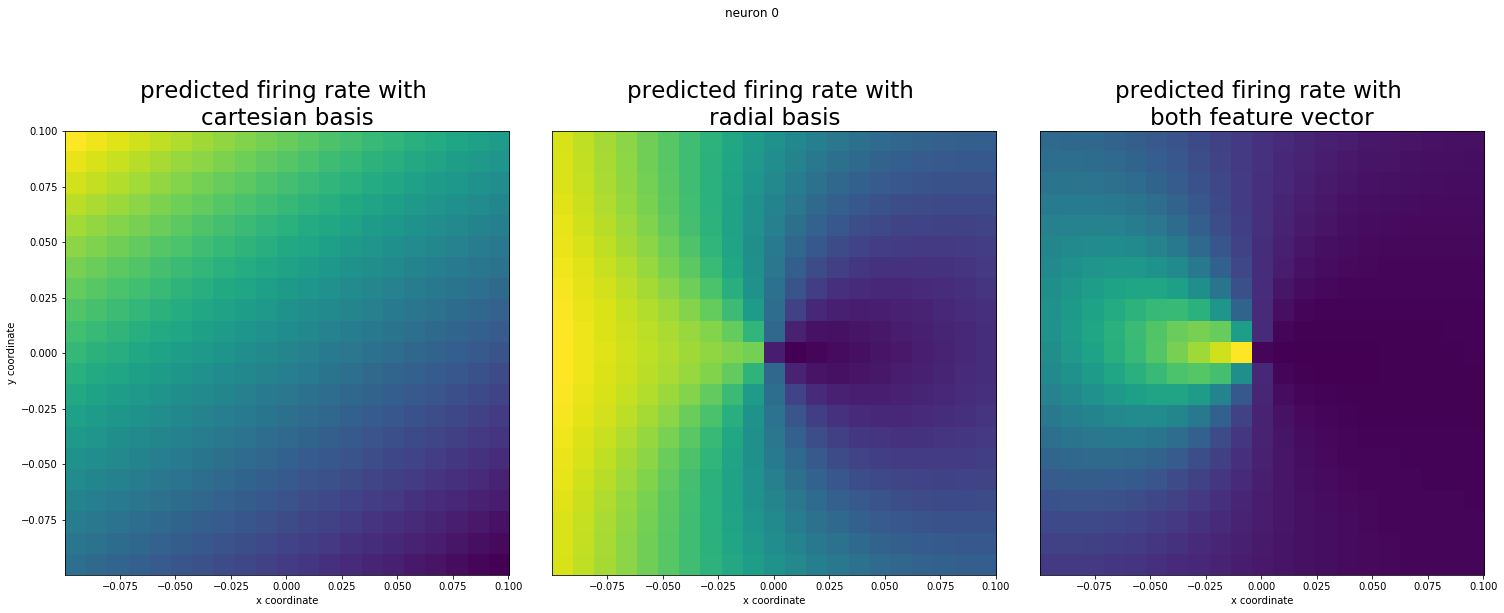

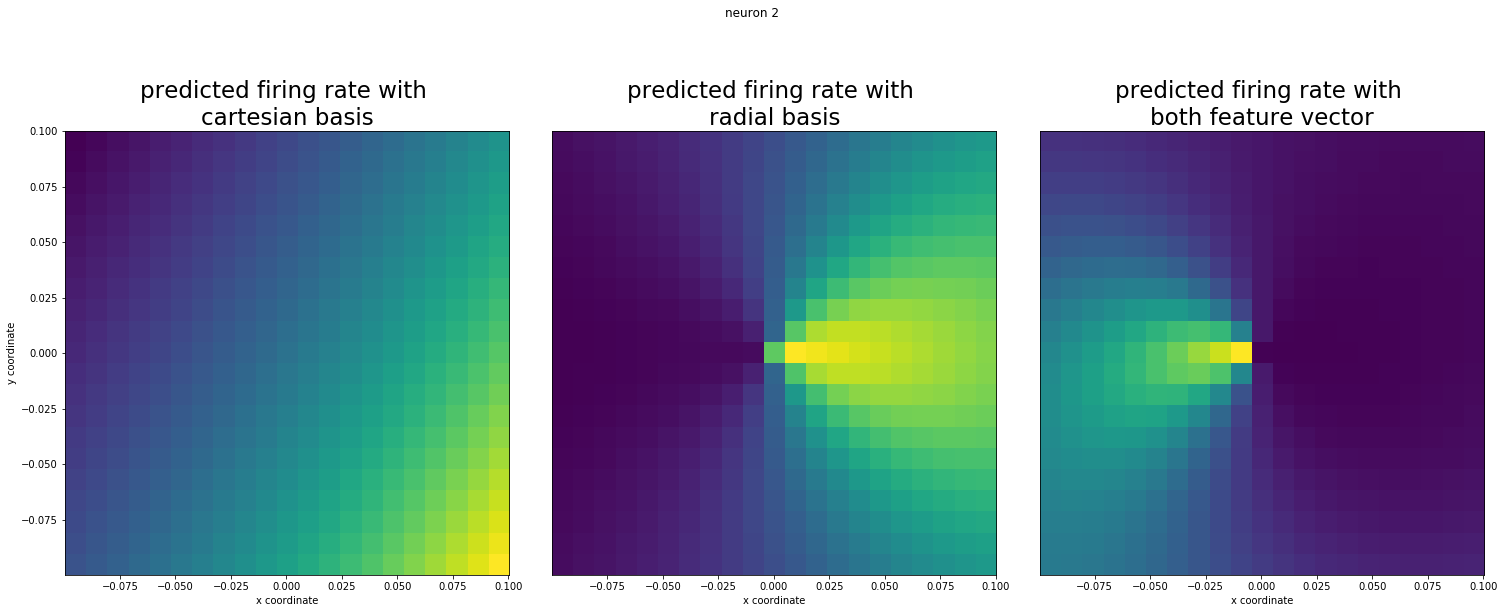

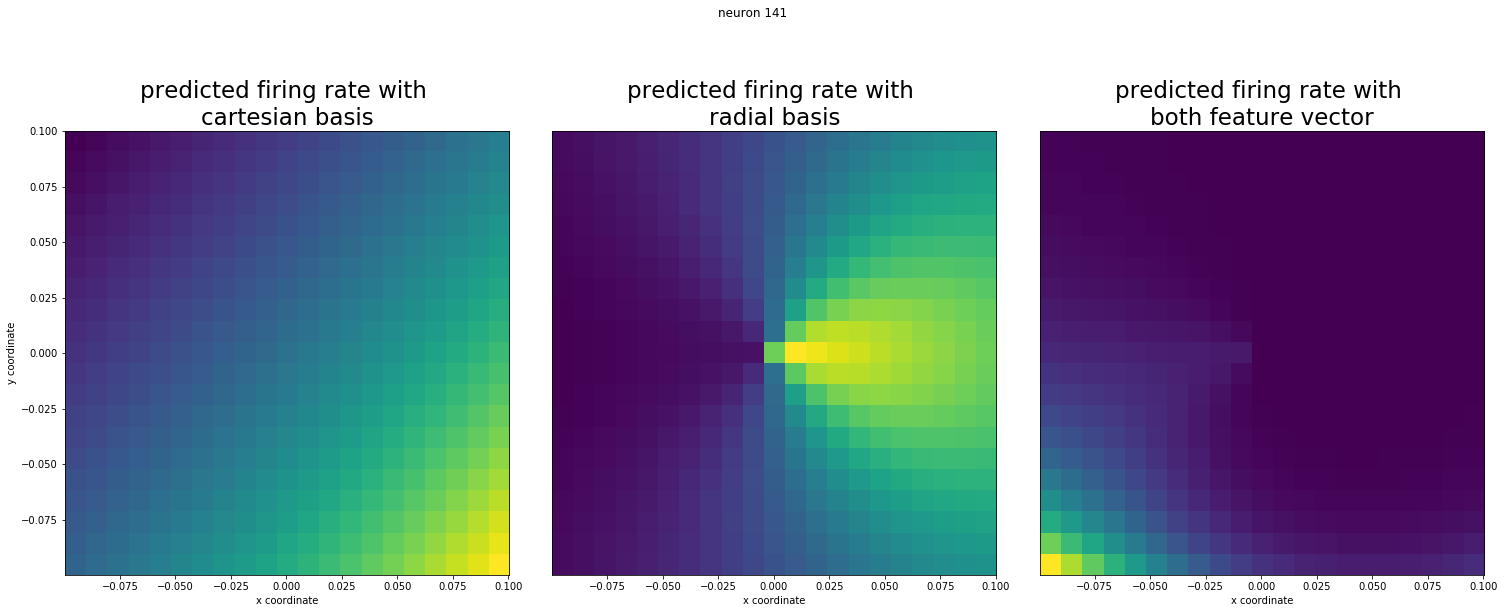

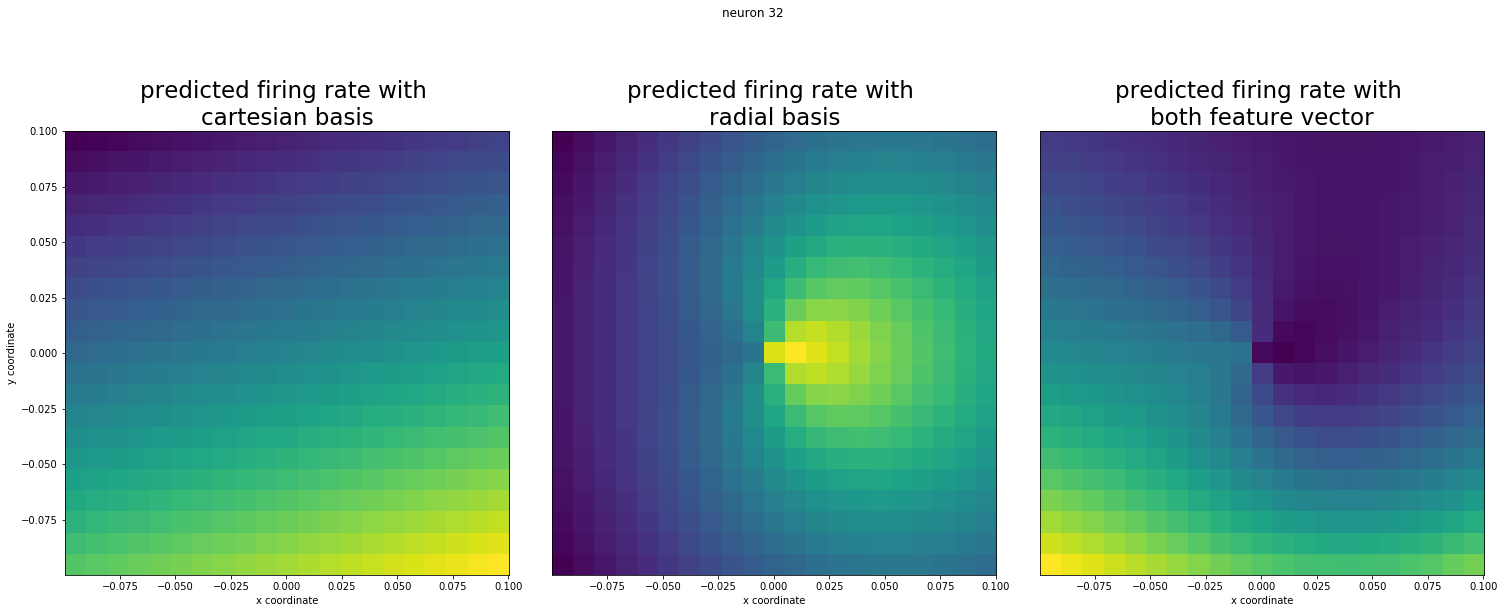

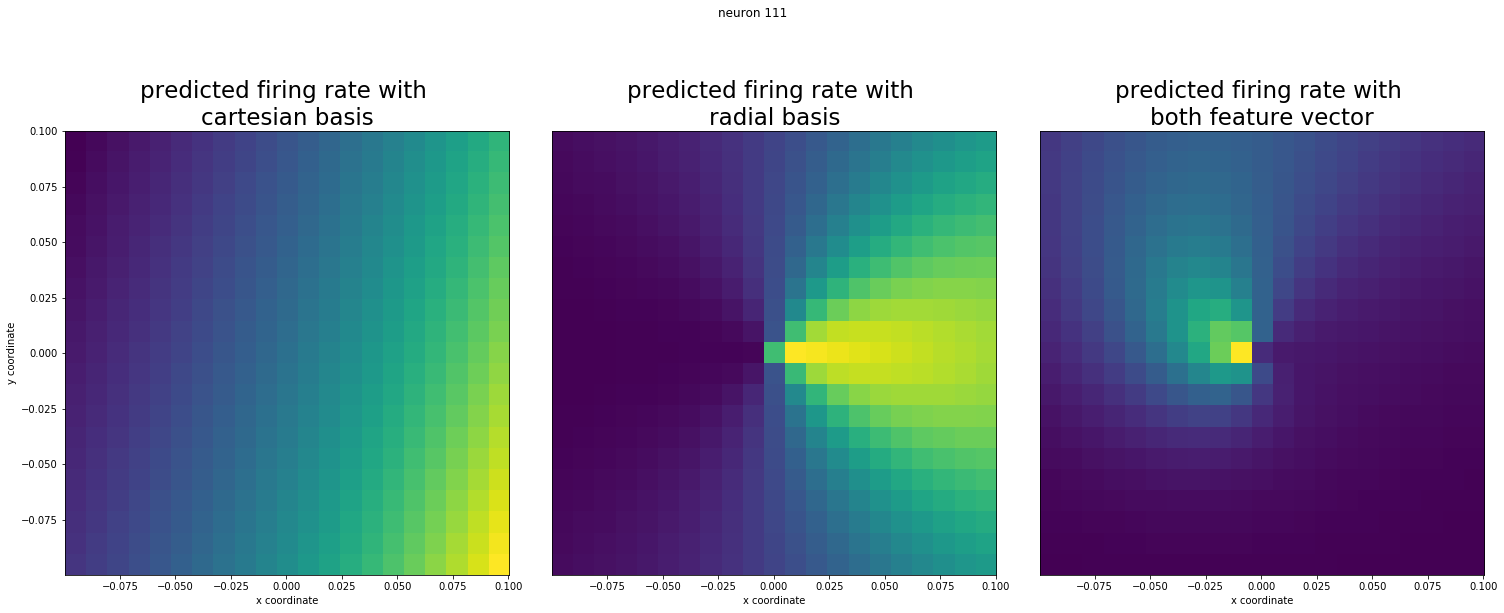

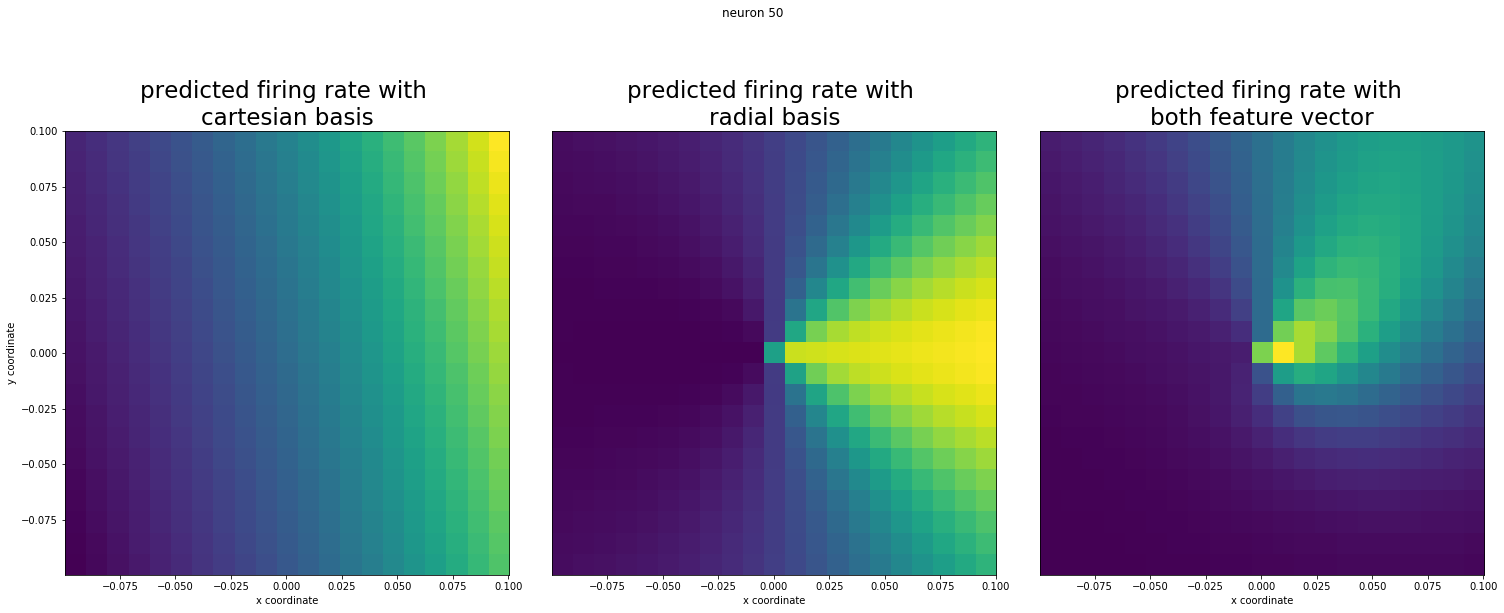

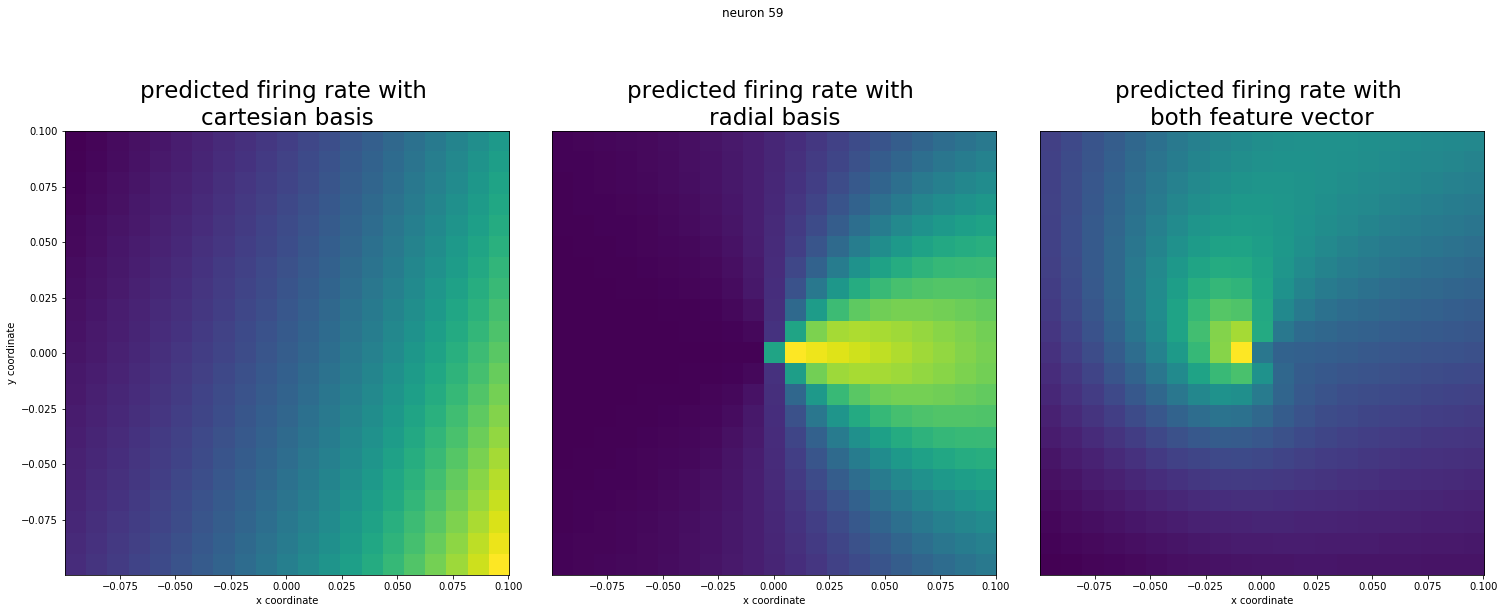

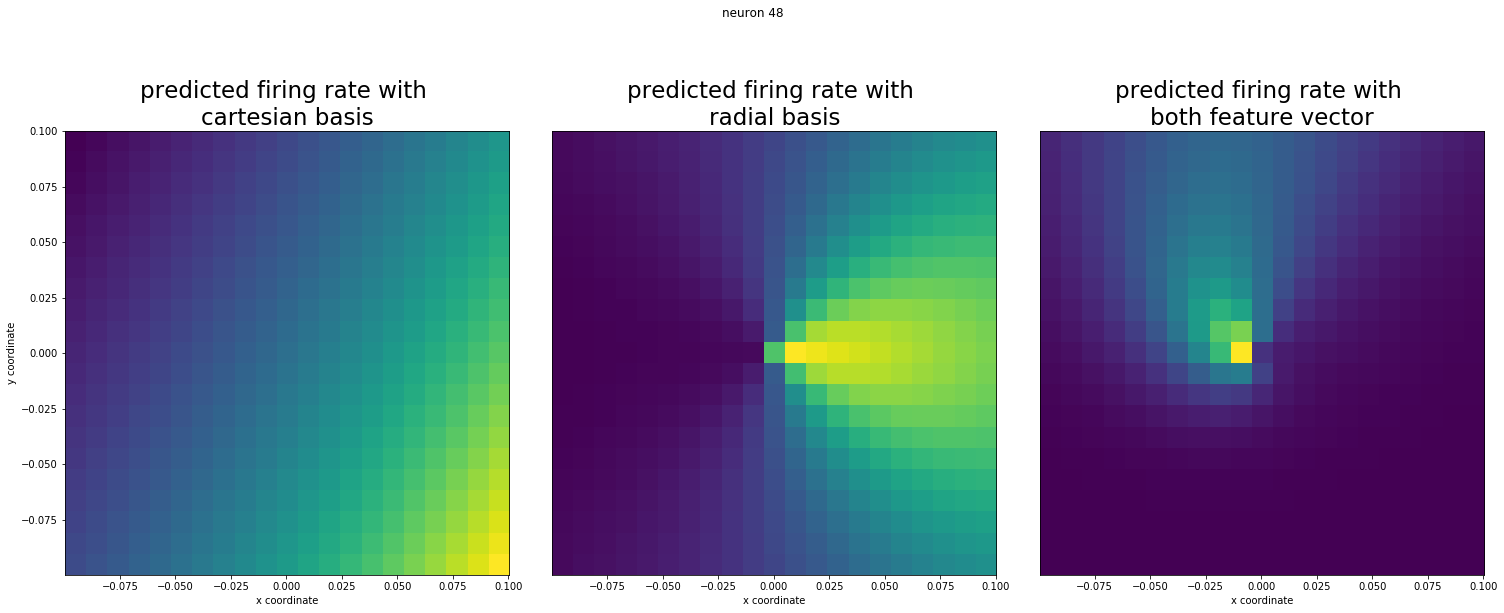

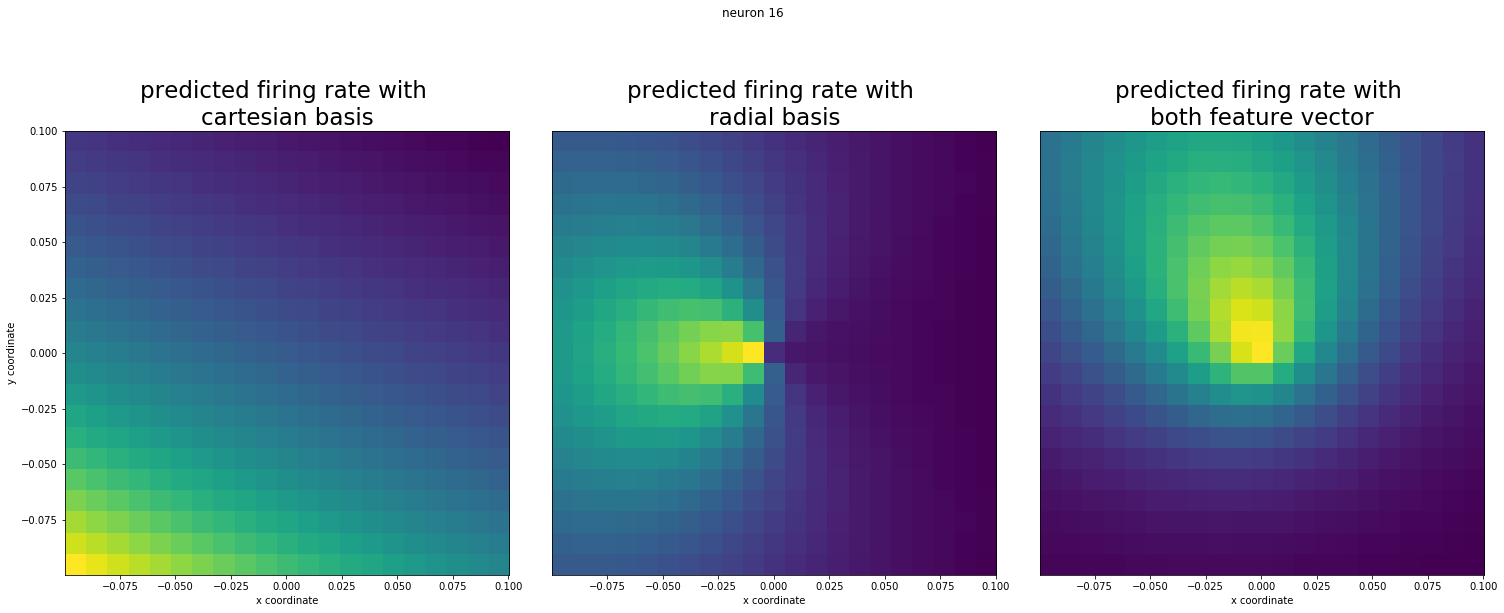

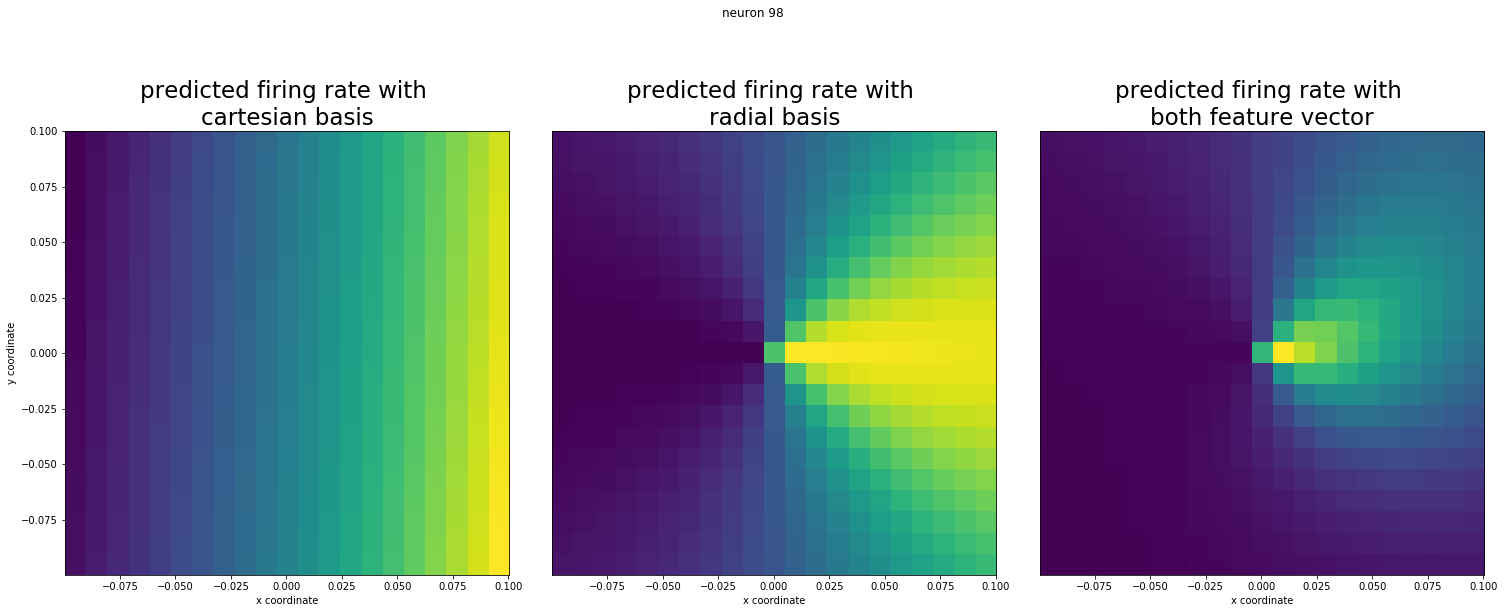

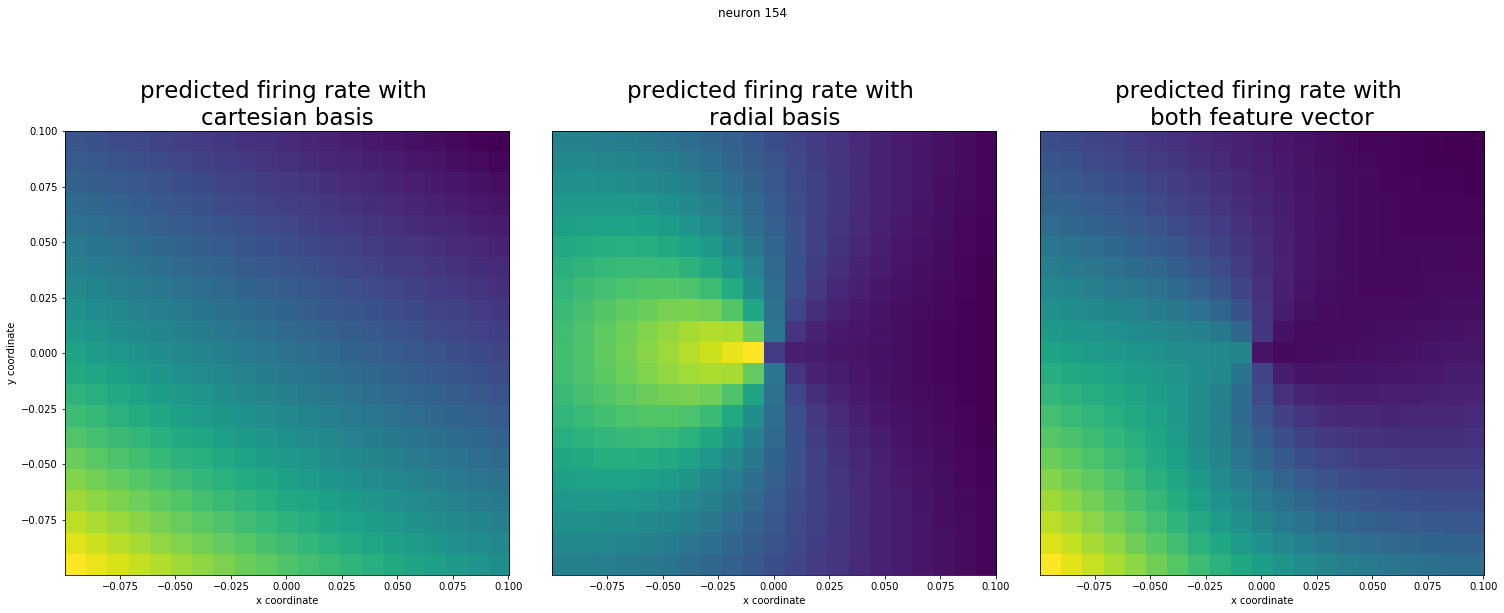

In [16]:
for i, ind in enumerate(best_neurons):
    poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
    run_model(best_neurons[i], X, Y_cart, Y_cart_dummy, xx_cart_coord)


    poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
    run_model(best_neurons[i], X, Y_rad, Y_rad_dummy, xx_cart_coord)

    poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
    run_model(best_neurons[i], X, Y_comb, Y_comb_dummy, xx_cart_coord)
    title = 'neuron ' + str(ind)
    plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title)

In [52]:
#sample from the inferred distribution
x_hat = results_cart.mu
samples = np.random.poisson(x_hat)

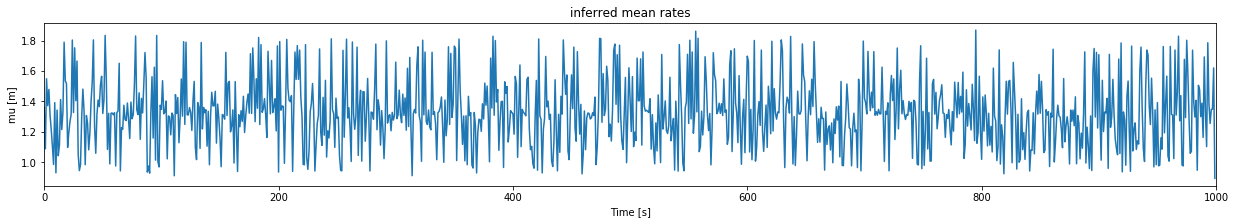

In [20]:
fig = plt.figure(figsize = (21, 3))
title = 'inferred mean rates'
plt.title(title)
minmax = (0, 1000)
plt.plot(x_hat[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.ylabel('mu [m]')
plt.xlim([minmax[0],minmax[1]])
plt.show()

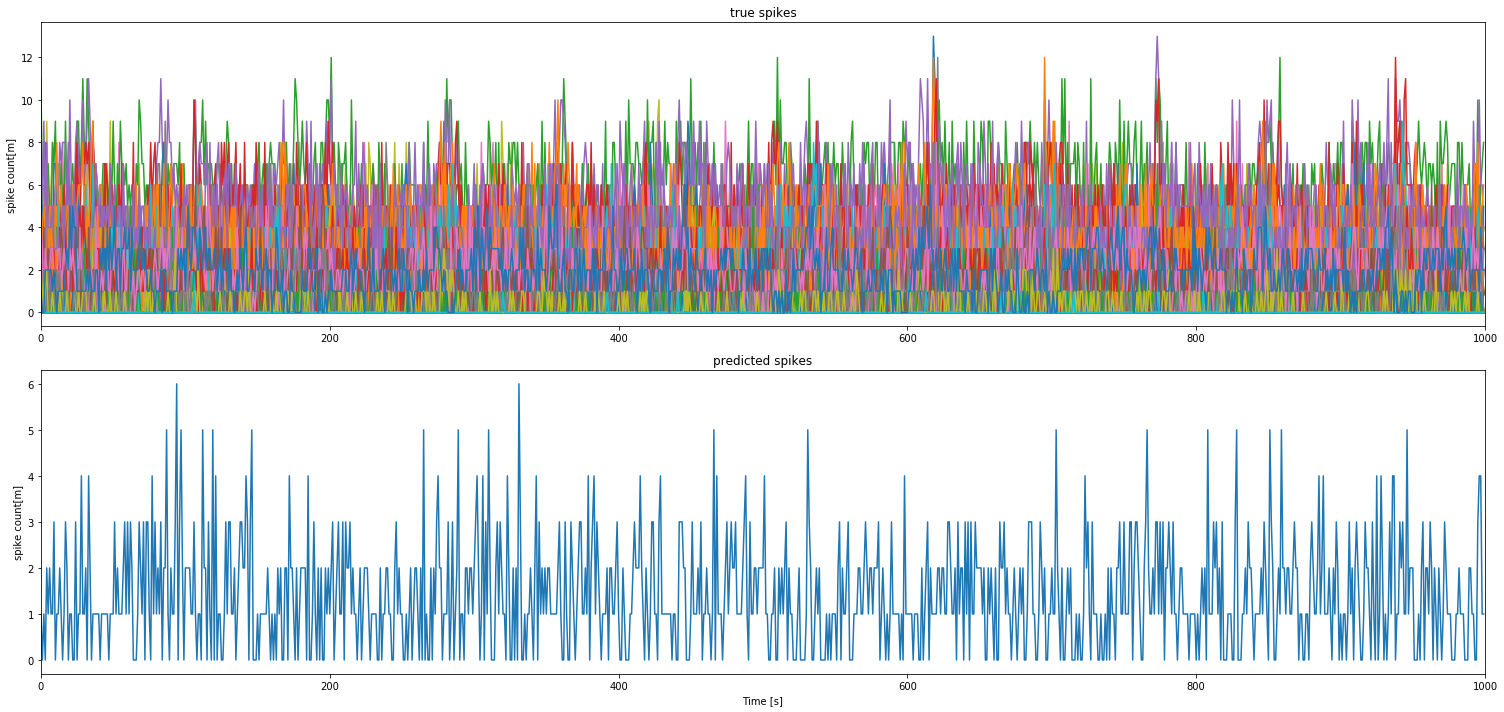

In [21]:
# sample from the inferred distribution 
fig = plt.figure(figsize = (21, 10))
title = 'inferred mean rates'
minmax = (0, 1000)
fig.add_subplot(2,1,1)
plt.plot(X_test[minmax[0]:minmax[1]])
# plt.xlabel('Time [s]')
plt.title('true spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
fig.add_subplot(2,1,2)
plt.plot(samples[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.title('predicted spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
plt.tight_layout()